# Load Datasets

In [1]:
import numpy as np
import pandas as pd
import os

import sklearn.tree
import sklearn.ensemble

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

In [2]:
# Clone repository in order to get access locally to the datasets
!rm -rf .git README.md
!git clone -b playing-emsembled-methods https://github.com/sergio-gimenez/anomaly-4G-detection 

fatal: destination path 'anomaly-4G-detection' already exists and is not an empty directory.


In [3]:
!ls -la

total 28
drwxr-xr-x 1 root root 4096 Jan  4 15:37 .
drwxr-xr-x 1 root root 4096 Jan  4 14:46 ..
drwxr-xr-x 3 root root 4096 Jan  4 15:33 anomaly-4G-detection
drwxr-xr-x 1 root root 4096 Dec 21 17:29 .config
-rw-r--r-- 1 root root 4404 Jan  4 15:37 missclassifications.csv
drwxr-xr-x 1 root root 4096 Dec 21 17:29 sample_data


In [4]:
train = pd.read_csv('anomaly-4G-detection/ML-MATT-CompetitionQT2021_train.csv', sep=';')
test = pd.read_csv('anomaly-4G-detection/ML-MATT-CompetitionQT2021_test.xls', sep=';' )

In [5]:
# Separate labels from data 
X = train.drop('Unusual', axis='columns')#.to_numpy()
y = train['Unusual']#.to_numpy()

# We split the data into training and validation subsets (80% and 20%) in
# order to validate our training
X_train, X_validation, y_train, y_validation = train_test_split(X, y, 
                                                                train_size=0.8,
                                                                random_state=1, stratify = y)
X_test = test

In [6]:
#Refactor time feature to minuts and cellName to unique identifier 1:1
def getTimeInMinutes(x):
  hh, mm  = x.split(":")
  return int(hh)* 60 + int(mm)

def createCellNameDictionary(data):
  cellList = []
  for i in data["CellName"]:
    cellList.append(i)
  cellList = set(cellList)
  cellDict = {}
  for idx, value in enumerate(cellList):
    cellDict[value]=idx
  return cellDict

def refactorFeaturesDataframe(data):
  data["Time"] = data["Time"].apply(lambda x: getTimeInMinutes(x))
  cellNameDict = createCellNameDictionary(data);
  data["CellName"] = data["CellName"].apply(lambda x: cellNameDict[x])
  return data


In [7]:
#Refactoring data from features to useful values
X_train = refactorFeaturesDataframe(X_train).to_numpy()
y_train = y_train.to_numpy()

X_validation = refactorFeaturesDataframe(X_validation).to_numpy()
y_validation = y_validation.to_numpy()

X_test = refactorFeaturesDataframe(test).to_numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Solving the Classification Problem

In [8]:
clf = sklearn.tree.DecisionTreeClassifier(random_state=1)
pipe = Pipeline(steps=[('std_slc', StandardScaler()),
                           ('dec_tree', clf)])

n_components = list(range(1,X_train.shape[1]+1,2))
criterion = ['gini', 'entropy']
max_depth = [None,2,8,12]
min_samples_split = [2,4,8,10]
min_samples_leaf = [1,2,5]

parameters = dict(dec_tree__criterion=criterion,
                      dec_tree__min_samples_split=min_samples_split,
                      dec_tree__min_samples_leaf=min_samples_leaf,
                      dec_tree__max_depth=max_depth)
#clf_GS = GridSearchCV(pipe, parameters)
#clf_GS.fit(X_train, y_train)

#clf.fit(X_train, y_train)

In [9]:
#pred_train = clf_GS.predict(X_train)
#pred_val = clf_GS.predict(X_validation)

## Voting Classifier with GridSearch

In [10]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from joblib import dump, load
from google.colab import files
from scipy.stats import uniform, randint

#if performVoting == 'y':
  
try:
  clf_GS = load('anomaly-4G-detection/voting_model.joblib') 
  

except:
  voting_clf = VotingClassifier( estimators=[ 
      ('xgb', XGBClassifier(random_state=1)),
      ('dt', DecisionTreeClassifier(random_state=1)),
      ('knn', KNeighborsClassifier())
      ], voting='soft')
  
  pipe = Pipeline(steps=[('std_slc', StandardScaler()),
                              ('voting_clf', XGBClassifier(random_state=1))])
  
  parameters = {
  #'voting_clf__dt__criterion'    : ['entropy', 'gini'],
  #'voting_clf__dt__min_samples_leaf'    : randint(2, 30),
  #'voting_clf__dt__min_samples_split'    : randint(2, 30),
  #'voting_clf__dt__max_depth'    : randint(2, 30),
  #'voting_clf__knn__n_neighbors'    : randint(5, 30),
  #'voting_clf__knn__metric'    : ['euclidean', 'manhattan'],
  #'voting_clf__knn__weights'    : ['uniform', 'distance'],
  #'voting_clf__knn__p'    : randint(1, 5),
  'voting_clf__eta'    : uniform(0.1, 0.3),
  "voting_clf__colsample_bytree": uniform(0.0, 0.3),
  "voting_clf__min_child_weight": randint(1, 5),
  "voting_clf__gamma": uniform(0, 0.5),
  "voting_clf__learning_rate": uniform(0.03, 0.3), # default 0.1 
  "voting_clf__max_depth": randint(2, 20), # default 3
  "voting_clf__n_estimators": randint(100, 1000), # default 100
  "voting_clf__subsample": uniform(0.9, 0.4)
  }

  #clf_GS = GridSearchCV(estimator=pipe, param_grid=parameters, n_jobs=10, verbose=1, )
  clf_GS = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=5, n_iter= 1000 )
  clf_GS.fit(X_train,y_train)

  #Save the model in a file and download locally.
  dump(clf_GS, 'voting_model.joblib')
  files.download('voting_model.joblib') 

In [11]:
pred_train = clf_GS.predict(X_train)
pred_val = clf_GS.predict(X_validation)

In [12]:
print("TRAINING\n" + classification_report(y_train, pred_train))
print("\nTESTING\n" + classification_report(y_validation, pred_val))

TRAINING
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21377
           1       1.00      1.00      1.00      8146

    accuracy                           1.00     29523
   macro avg       1.00      1.00      1.00     29523
weighted avg       1.00      1.00      1.00     29523


TESTING
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5344
           1       1.00      0.98      0.99      2037

    accuracy                           0.99      7381
   macro avg       1.00      0.99      0.99      7381
weighted avg       0.99      0.99      0.99      7381



In [13]:
train_error = 1. - accuracy_score(y_train, pred_train)
train_cmat = confusion_matrix(y_train, pred_train)
val_error = 1. - accuracy_score(y_validation, pred_val)
val_cmat = confusion_matrix(y_validation, pred_val)

print('train error: %f ' % train_error)
print('train confusion matrix:')
print(train_cmat)
print('test error: %f ' % val_error)
print('test confusion matrix:')
print(val_cmat)

train error: 0.001016 
train confusion matrix:
[[21377     0]
 [   30  8116]]
test error: 0.006774 
test confusion matrix:
[[5344    0]
 [  50 1987]]


### Analyzing Missclassified Data

In [14]:
from tabulate import tabulate
X_miss= []
y_miss = [] # Valor de las muestras mal clasificadas
y_miss_global = [] # Índice de las muestras mal clasificadas
for input, prediction, label in zip(X_validation, pred_val, y_validation):
  if prediction != label:
    X_miss.append(input.tolist())
    y_miss.append(label)
    #print(input, 'has been classified as ', prediction, 'and should be ', label, '\n')
    y_miss_global.append('miss')
  else:
    y_miss_global.append('hit')

#table = tabulate(X_miss, headers=['Time','CellName','PRBUsageUL','PRBUsageDL','meanThr_DL','meanThr_UL','maxThr_DL','maxThr_UL','meanUE_DL','meanUE_UL','maxUE_DL','maxUE_UL','maxUE_UL+DL'], tablefmt="fancy_grid")
#print(table)

miss_dataframe = pd.DataFrame(X_miss, columns=['Time','CellName','PRBUsageUL','PRBUsageDL','meanThr_DL','meanThr_UL','maxThr_DL','maxThr_UL','meanUE_DL','meanUE_UL','maxUE_DL','maxUE_UL','maxUE_UL+DL']) 
miss_dataframe.to_csv('missclassifications.csv', index=True)
print(miss_dataframe)

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#### 3D Plot

##### All samples

In [17]:
colors=['blue' if l=='hit' else 'red' for l in y_miss_global]

In [18]:
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
X_valdiation_norm = scaler.fit_transform(X_validation)
X_validation_reduce = pca.fit_transform(X_valdiation_norm)

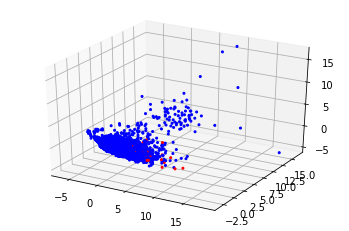

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_validation_reduce[:,0], X_validation_reduce[:, 1], X_validation_reduce[:, 2], s=4, alpha=1,color=colors)
plt.show()

##### Only missclassified samples

In [20]:
colors=['green' if l==0 else 'red' for l in y_miss]

In [21]:
pca = PCA(n_components=3)
scaler = StandardScaler()
X_miss_norm = scaler.fit_transform(X_miss)
X_miss_reduce = pca.fit_transform(X_miss_norm)

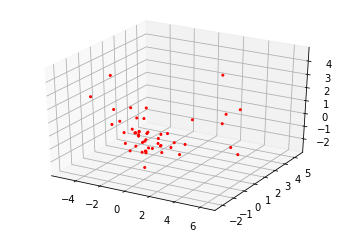

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_miss_reduce[:,0], X_miss_reduce[:, 1], X_miss_reduce[:, 2], s=4, alpha=1,color=colors)
plt.show()

#### 2D Plot

##### All samples

In [23]:
colors=['blue' if l=='hit' else 'red' for l in y_miss_global]

In [24]:
pca = PCA(n_components=2)  # Reduce to k=2 dimensions
scaler = StandardScaler()
X_valdiation_norm = scaler.fit_transform(X_validation)
X_validation_reduce = pca.fit_transform(X_valdiation_norm)

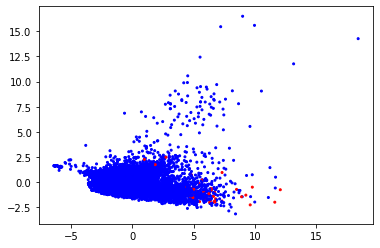

In [25]:
fig, ax = plt.subplots()
ax.scatter(X_validation_reduce[:,0], X_validation_reduce[:, 1], s=4,color=colors)
plt.show()

##### Only missclassified samples

In [26]:
colors=['green' if l==0 else 'red' for l in y_miss]

In [27]:
pca = PCA(n_components=2)
scaler = StandardScaler()
X_miss_norm = scaler.fit_transform(X_miss)
X_miss_reduce = pca.fit_transform(X_miss_norm)

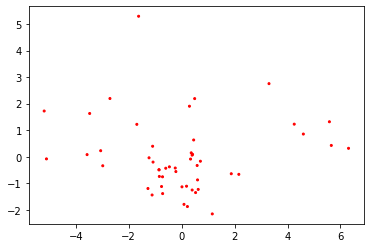

In [28]:
fig, ax = plt.subplots()
ax.scatter(X_miss_reduce[:,0], X_miss_reduce[:, 1], s=4,color=colors)
plt.show()

# Submission Formatting

In [29]:
pred_test = clf_GS.predict(X_test)

In [30]:
%%shell
# Create submission file if it does not exists
file=predictions.csv
if [ ! -e "$file" ] ; then
    touch anomaly-4G-detection/"$file"
fi

In [31]:
# Create index column in data frame object
submission_dataframe = pd.DataFrame(np.arange(1, 9159), columns=['Id']) 

# Append predictions of test data as column
submission_dataframe['Label'] = pred_test

# Convert Data Frame object to CSV
submission_dataframe.to_csv('predictions.csv', index=False)

!mv predictions.csv anomaly-4G-detection/
predictions = pd.read_csv('anomaly-4G-detection/predictions.csv')
predictions

,Id,Label
0,1,1
1,2,0
2,3,0
3,4,0
4,5,1
...,...,...
9153,9154,0
9154,9155,1
9155,9156,0
9156,9157,0


In [32]:
#!rm anomaly-4G-detection/predictions.csv

In [33]:
clf_GS.best_params_
#print(clf_GS.grid_scores_)

{'voting_clf__colsample_bytree': 0.08216376983211655,
 'voting_clf__eta': 0.3035863100820831,
 'voting_clf__gamma': 0.8025688925845532,
 'voting_clf__learning_rate': 0.1350522573909821,
 'voting_clf__max_depth': 22,
 'voting_clf__min_child_weight': 1,
 'voting_clf__n_estimators': 672,
 'voting_clf__subsample': 0.9863216350553967}